In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import configparser
import os
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.analysis_utils as analysis

import aps.ai.autoalignment.beamline28IDB.optimization.analysis_plot_utils as apu
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import scipy
import cmasher as cmm
from IPython.display import Image, display_png

from epics import ca
ca.finalize_libca()

%matplotlib inline

In [3]:
exp_type = 'fwhm_lwsi'

In [31]:
#base_dir = Path(aps.__file__).parents[1]
autoalign_dir = Path("/Users/skandel/Library/CloudStorage/Box-Box/Beamtime_28ID_Nov2022/AI/autofocusing")
data_base_dir = autoalign_dir / exp_type / 'all_motors'
print(f'data base dir exists {data_base_dir.exists()}')


data base dir exists True


In [32]:
log_files = sorted(list(data_base_dir.glob('*.gz')))
hist_dirs = sorted(list(data_base_dir.glob('*steps')))
ini_files = sorted(list(data_base_dir.glob('*ini')))
image_dirs = sorted(list(data_base_dir.glob('*images')))
log_files, hist_dirs, ini_files

([PosixPath('/Users/skandel/Library/CloudStorage/Box-Box/Beamtime_28ID_Nov2022/AI/autofocusing/fwhm_lwsi/all_motors/fwhm_lwsi_moo_optimization_final_151_2022-11-21_07:04.gz')],
 [PosixPath('/Users/skandel/Library/CloudStorage/Box-Box/Beamtime_28ID_Nov2022/AI/autofocusing/fwhm_lwsi/all_motors/fwhm_lwsi_moo_150_2022-11-21_steps')],
 [PosixPath('/Users/skandel/Library/CloudStorage/Box-Box/Beamtime_28ID_Nov2022/AI/autofocusing/fwhm_lwsi/all_motors/fwhm_lwsi_moo_autofocusing.ini')])

### fwhm_lwsi

In [33]:
!ls $data_base_dir

fwhm_lwsi_moo_150_2022-11-21_images
fwhm_lwsi_moo_150_2022-11-21_steps
fwhm_lwsi_moo_autofocusing.ini
fwhm_lwsi_moo_optimization_final_151_2022-11-21_07:04.gz


In [38]:
study_gzs = list(data_base_dir.glob("fwhm_lwsi_*11-21*.gz"))
study_gzs

[PosixPath('/Users/skandel/Library/CloudStorage/Box-Box/Beamtime_28ID_Nov2022/AI/autofocusing/fwhm_lwsi/all_motors/fwhm_lwsi_moo_optimization_final_151_2022-11-21_07:04.gz')]

In [39]:
study = analysis.create_study_from_trials( study_gzs[0])

[I 2023-08-06 18:12:37,387] A new study created in memory with name: no-name-e0b28e5d-1a7f-4821-8b0e-2455354ab1f3


Assuming minimization for all objectives.


In [40]:
n_steps = len(study.trials)

In [41]:
hists = analysis.load_histograms_from_files(n_steps, hist_dirs[0], extension='gz')

In [42]:
base_out_dir = Path("/Users/skandel/Library/CloudStorage/Box-Box/autofocus_paper/figures/fwhm_lwsi")
base_out_dir.mkdir(exist_ok=True)

In [43]:
out_dir = base_out_dir
out_dir.mkdir(exist_ok=True)

In [44]:
dwds = [dict(**t.user_attrs["dw"]._DictionaryWrapper__dictionary) for t in study.trials]

Trial values: centroid 4.031e-02 fwhm 1.931e+01
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.39052315363709056, 'h_fwhm': 0.038367762853175336, 'h_centroid': -0.005710653187328857, 'h_peak': -0.08226308476146366, 'v_sigma': 0.4574363315023405, 'v_fwhm': 0.012354826103947447, 'v_centroid': 0.008500454616057779, 'v_peak': -0.040640875341930525, 'integral_intensity': 285.5085164402284, 'peak_intensity': 42462.715, 'gaussian_fit': {}}}
Trial mots
dict_items([('hb_1', 0.0), ('hb_2', 0.0), ('hb_pitch', 0.0), ('hb_trans', 0.0), ('vb_bender', 0.0), ('vb_pitch', 0.0), ('vb_trans', 0.0)])


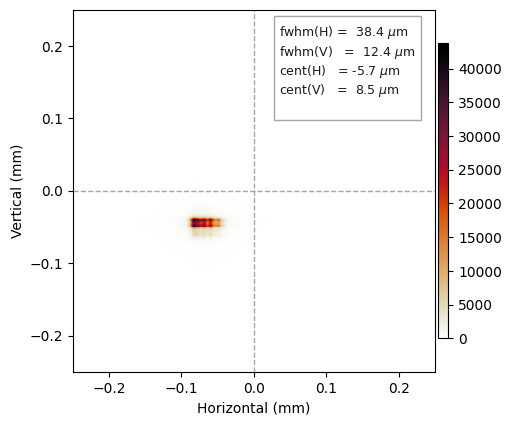

In [45]:
print(
    f"Trial values: centroid {study.trials[0].values[0]:4.3e} fwhm {study.trials[0].values[1]:4.3e}"
)
print("Trial dw:")
print(study.trials[0].user_attrs["dw"].__dict__)

dwd = dict(**study.trials[0].user_attrs["dw"]._DictionaryWrapper__dictionary)

print('Trial mots')
print(study.trials[0].params.items())


plt.figure(figsize=[5, 5], constrained_layout=True)
plt.pcolormesh(
    hists[0].hh,
    hists[0].vv,
    hists[0].data_2D.T[::-1],
    cmap=apu.CMAP,
    #norm=mpl.colors.LogNorm(100, max_count),
    rasterized=True,
)
plt.xlim(-0.25, 0.25)
plt.ylim(-0.25, 0.25)
plt.axhline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.axvline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.xlabel("Horizontal (mm)")
plt.ylabel("Vertical (mm)")
# plt.title("Initial")
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect("equal")

text = (
    rf"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 2.1f} $\mu$m" + "\n"
    rf"{'fwhm(V)':<9} = {dwd['v_fwhm'] * 1000: 2.1f} $\mu$m" + "\n"
    rf"{'cent(H)':<9} = {dwd['h_centroid'] * 1000: 2.1f} $\mu$m" + "\n"
    rf"{'cent(V)':<9} = {dwd['v_centroid'] * 1000: 2.1f} $\mu$m" + "\n"
)
ax.text(
    0.035, 0.11, text, color="black", alpha=0.9, fontsize=9, bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7)
)
#plt.savefig(f"{out_dir}/initial.svg", bbox_inches="tight", dpi=600)
plt.show()

In [46]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

In [47]:
print(n_doms)
print(nash_trial.number, nash_trial.values)
print(nash_trial.user_attrs["dw"].__dict__)

[119, 47, 111, 135, 96]
104 [0.011073893725051806, 19.312389656018144]
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3902502497951537, 'h_fwhm': 0.008453913849004735, 'h_centroid': -0.001539525846844747, 'h_peak': -0.03023899953682259, 'v_sigma': 0.4575851057344179, 'v_fwhm': 0.007152794060180101, 'v_centroid': 0.008006876983707806, 'v_peak': -0.030887065259867123, 'integral_intensity': 285.1398900118104, 'peak_intensity': 65360.57, 'gaussian_fit': {}}}


Trial number 32
Trial values: centroid 1.016e-02 fwhm 1.931e+01
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.39043978814677066, 'h_fwhm': 0.0078036127836966784, 'h_centroid': 0.0029190650111451666, 'h_peak': 0.029588698471514522, 'v_sigma': 0.4574554581747944, 'v_fwhm': 0.006502540054709183, 'v_centroid': 0.004888883997067106, 'v_peak': 0.01333020711215313, 'integral_intensity': 285.2441641200766, 'peak_intensity': 65226.77, 'gaussian_fit': {}}}
Actual fwhm 0.01015772610582563


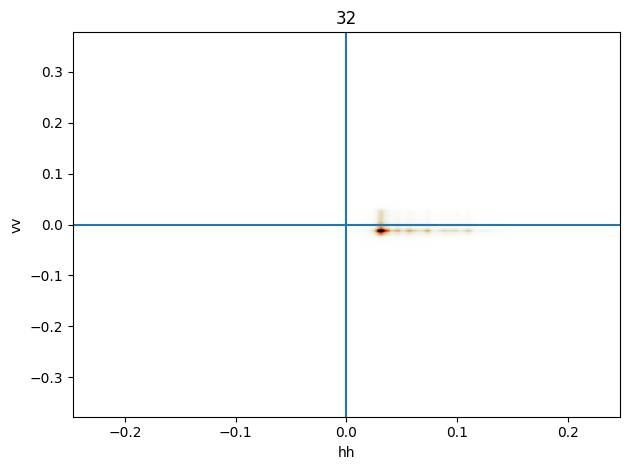

Trial number 54
Trial values: centroid 1.890e-02 fwhm 1.931e+01
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3900436170114078, 'h_fwhm': 0.012355720240853074, 'h_centroid': 0.0006471807768093363, 'h_peak': 0.015282075034738274, 'v_sigma': 0.45730186230452335, 'v_fwhm': 0.014305588120360202, 'v_centroid': 0.005458513959218814, 'v_peak': 0.0029261430246188755, 'integral_intensity': 285.2527431214575, 'peak_intensity': 64818.812, 'gaussian_fit': {}}}
Actual fwhm 0.01890274250312947


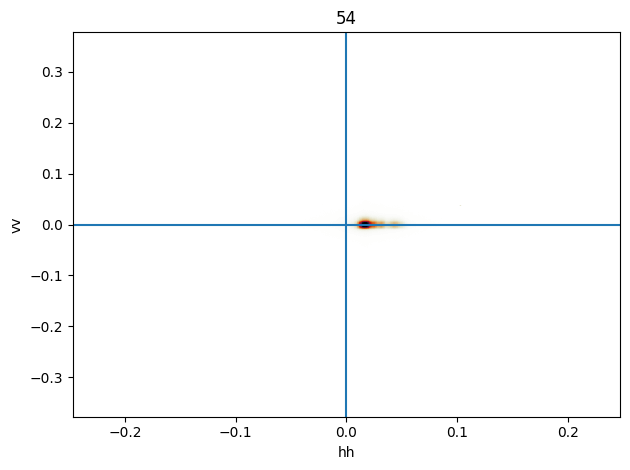

Trial number 58
Trial values: centroid 1.334e-02 fwhm 1.931e+01
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.39034668831816394, 'h_fwhm': 0.009104214914312792, 'h_centroid': -0.0032223574569992808, 'h_peak': -0.048447429365447006, 'v_sigma': 0.4574800462416792, 'v_fwhm': 0.009753810082063774, 'v_centroid': 0.006238300929090529, 'v_peak': -0.007477921062915232, 'integral_intensity': 285.13577642124295, 'peak_intensity': 65343.4, 'gaussian_fit': {}}}
Actual fwhm 0.013342546245861935


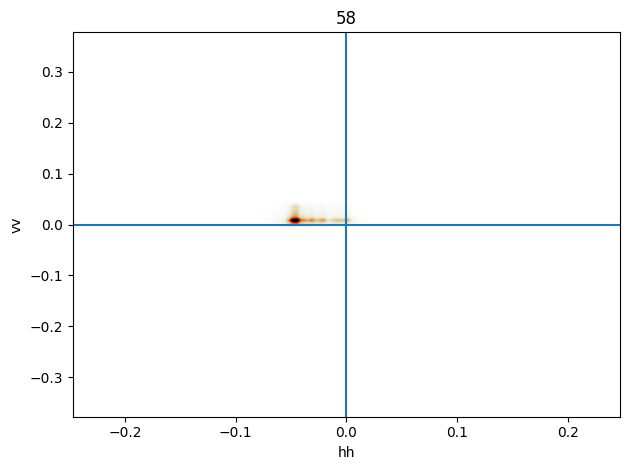

Trial number 104
Trial values: centroid 1.107e-02 fwhm 1.931e+01
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3902502497951537, 'h_fwhm': 0.008453913849004735, 'h_centroid': -0.001539525846844747, 'h_peak': -0.03023899953682259, 'v_sigma': 0.4575851057344179, 'v_fwhm': 0.007152794060180101, 'v_centroid': 0.008006876983707806, 'v_peak': -0.030887065259867123, 'integral_intensity': 285.1398900118104, 'peak_intensity': 65360.57, 'gaussian_fit': {}}}
Actual fwhm 0.011073893725051806


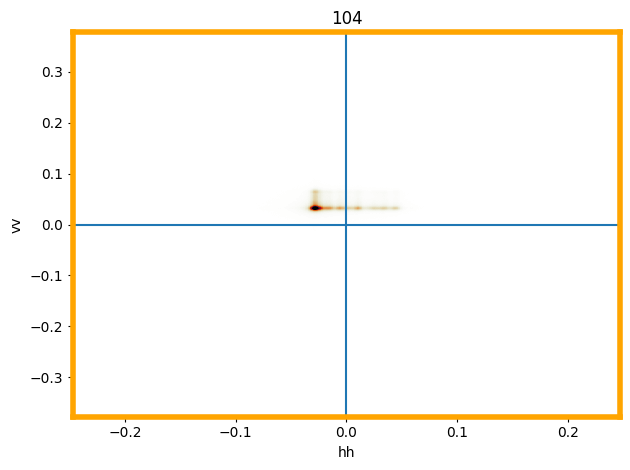

Trial number 131
Trial values: centroid 1.426e-02 fwhm 1.931e+01
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3901631250253206, 'h_fwhm': 0.010404817044928905, 'h_centroid': -0.0019494414675460814, 'h_peak': -0.030889300602130652, 'v_sigma': 0.45733815449954907, 'v_fwhm': 0.009753810082063774, 'v_centroid': 0.006333799383927974, 'v_peak': -0.006827667057444388, 'integral_intensity': 285.21845417902995, 'peak_intensity': 65194.78, 'gaussian_fit': {}}}
Actual fwhm 0.014261733024265038


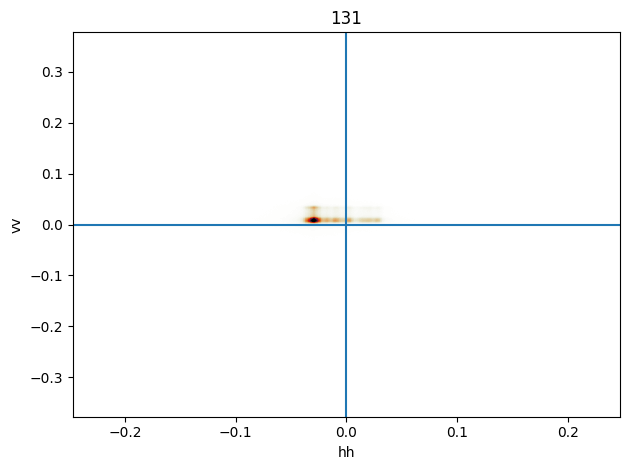

In [48]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: centroid {t.values[0]:4.3e} fwhm {t.values[1]:4.3e}")
    print("Trial dw:")
    print(t.user_attrs["dw"].__dict__)
    print("Actual fwhm", opt_common._get_fwhm_from_dw(t.user_attrs["dw"]))
    hist = hists[t.number]
    plt.pcolormesh(hist.hh[700:-700], hist.vv[700:-700], hist.data_2D[700:-700, 700:-700].T, cmap=apu.CMAP)
    if t.number == nash_trial.number:
        for axis in ["top", "bottom", "left", "right"]:
            plt.gca().spines[axis].set_linewidth(4)
            plt.gca().spines[axis].set_color("orange")
    plt.xlabel("hh")
    plt.ylabel("vv")
    plt.axhline(0)
    plt.axvline(0)
    plt.title(t.number)
    plt.tight_layout()
    plt.show()

Result: Seems like the beam is too spread out in all the cases.

In [51]:
pareto_df = analysis.get_pareto_dataframe_from_study(study, ["fwhm", "lwsi"])

In [52]:
pareto_df

,number,fwhm,lwsi,h_peak,v_peak,h_fwhm,v_fwhm,peak_intensity
32,32,0.010158,19.312742,0.029589,0.013330,0.007804,0.006503,65226.769531
54,54,0.018903,19.311522,0.015282,0.002926,0.012356,0.014306,64818.812500
58,58,0.013343,19.312270,-0.048447,-0.007478,0.009104,0.009754,65343.398438
104,104,0.011074,19.312390,-0.030239,-0.030887,0.008454,0.007153,65360.570312
131,131,0.014262,19.311790,-0.030889,-0.006828,0.010405,0.009754,65194.781250


In [53]:
c1 = [nash_trial.number]
c2 = [t.number for t in study.best_trials if t.number not in c1]
c3 = [n for n in range(len(hists)) if n not in c1 and n not in c2]

In [54]:
c2

[32, 54, 58, 131]

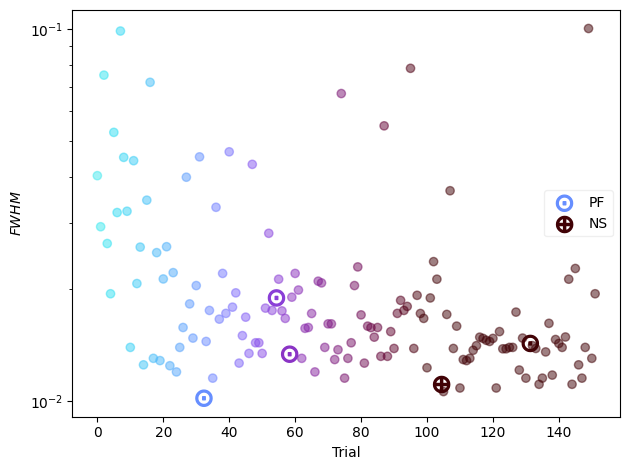

In [55]:
# Plotting the optimization histories
# optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
# plt.scatter(study.trials.values


plt.figure()
x = np.array([t.number for t in study.trials])
y = np.array([t.values[0] for t in study.trials])

plt.scatter(x[c3], y[c3], c=c3, cmap=cmm.gem_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(x[c2], y[c2], c=c2, cmap=cmm.gem_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF")
plt.scatter(
    x[c1], y[c1], c=c1, cmap=cmm.gem_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="NS"
)

plt.xlabel("Trial")
plt.ylabel("$FWHM$")
plt.yscale("log")
# for t in study.best_trials[:-1]:
#    plt.axvline(t.number, color='red', ls=':')
# plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
# plt.axvline(nash_trial.number, color='orange', label='NS')
plt.legend(loc="best", framealpha=0.3)
plt.tight_layout()
plt.show()

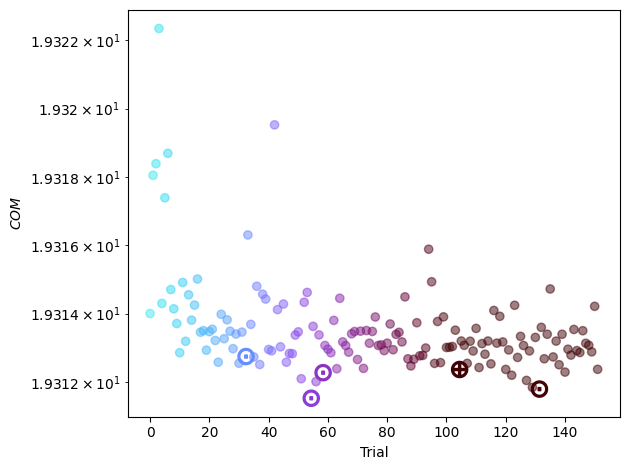

In [56]:
# Plotting the optimization histories
# optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
# plt.scatter(study.trials.values
plt.figure()
x = np.array([t.number for t in study.trials])
y = np.array([t.values[1] for t in study.trials])

plt.scatter(x[c3], y[c3], c=c3, cmap=cmm.gem_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(x[c2], y[c2], c=c2, cmap=cmm.gem_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF")
plt.scatter(
    x[c1], y[c1], c=c1, cmap=cmm.gem_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="NS"
)

plt.xlabel("Trial")
plt.ylabel("$COM$")
plt.yscale("log")
# for t in study.best_trials[:-1]:
#    plt.axvline(t.number, color='red', ls=':')
# plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
# plt.axvline(nash_trial.number, color='orange', label='NS')
plt.tight_layout()
plt.show()

In [57]:
ntrials = len(study.trials)

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_13287/1893553618.py:36: MatplotlibDeprecationWarning: The execute_constrained_layout function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.get_layout_engine().execute() instead.
  fig.execute_constrained_layout()


4.03927307532769 4.367882222221216


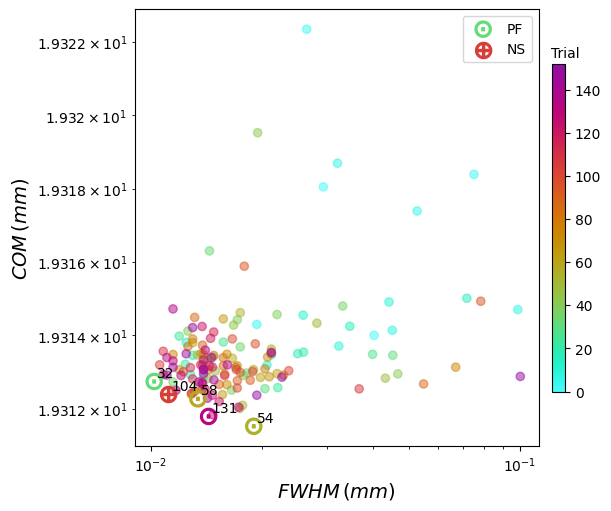

In [58]:
x = np.array([t.values[0] for t in study.trials])
y = np.array([t.values[1] for t in study.trials])

fig = plt.figure(figsize=[6, 5], constrained_layout=True)
plt.scatter(x[c3], y[c3], c=c3, cmap=cmm.tropical_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, ntrials))
plt.scatter(
    x[c2], y[c2], c=c2, cmap=cmm.tropical_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, ntrials), label="PF"
)
plt.scatter(
    x[c1],
    y[c1],
    c=c1,
    cmap=cmm.tropical_r,
    marker=r"$\oplus$",
    s=175,
    norm=mpl.colors.Normalize(0, ntrials),
    label="NS",
)

for t in study.best_trials:
    plt.annotate(t.number, xy=(x[t.number], y[t.number]), xytext=(3, 3), textcoords="offset points")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$FWHM\,(mm)$", fontsize=14)
plt.ylabel("$COM\,(mm)$", fontsize=14)
cbar = plt.colorbar(pad=0.03, aspect=25, shrink=0.75, location="right")
# cbar.ax.set_ylabel('Trial')
cbar.ax.text(-0.1, 155.0, "Trial")
# cbar.ax.set_xlabel('Trial')#, fontsize=14)

# plt.scatter(ground['fwhm'], ground['peak_distance'], color='red', marker='*', s=175, label='M')
plt.legend(loc="best")
r = fig.canvas.get_renderer()
ax = plt.gca()

fig.execute_constrained_layout()
print(ax.bbox.width / fig.dpi, ax.bbox.height / fig.dpi)
#plt.savefig(f"{out_dir}/pareto_fwhm_pl.svg", bbox_inches="tight", dpi=600)
plt.show()

### Combining the figures into one

In [59]:
import matplotlib.gridspec as gridspec

In [60]:
props = apu.AnalyzedProps(study, nash_trial, max_count=np.inf, min_count=200, xylim=0.25, photon_count_str="3.1e")

In [61]:
out_dir

PosixPath('/Users/skandel/Library/CloudStorage/Box-Box/autofocus_paper/figures/fwhm_lwsi')

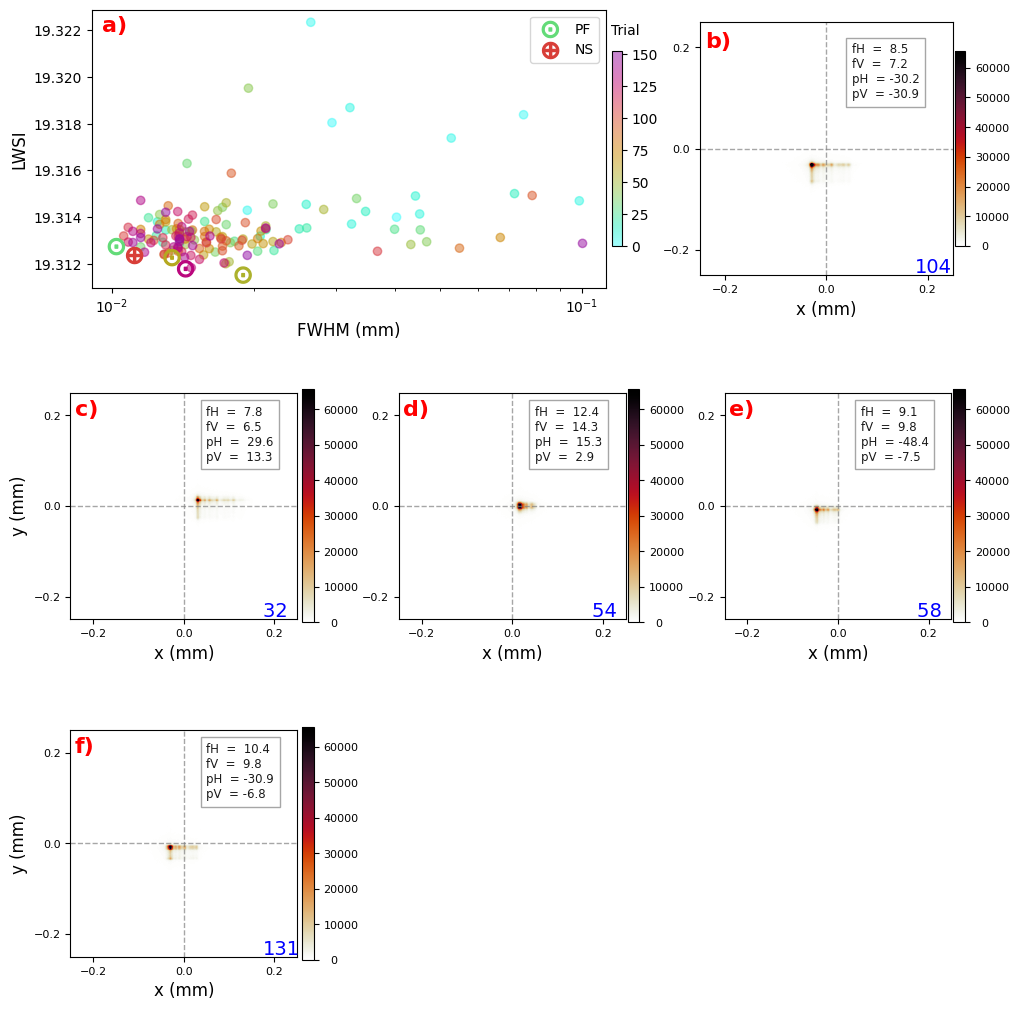

In [73]:
apu.PARETO_PLOT_ORDER = {"FWHM":0, "LWSI":1}

fig = plt.figure(figsize=[10, 10], layout="constrained")
gs0 = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[0.33, 0.67])

# top row
gss0 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0], width_ratios=[0.67, 0.33])
axs00 = fig.add_subplot(gss0[0])

cscatter, sublabel = apu.plot_pareto_2d(
    props, axs00, "FWHM", "LWSI", sublabel='a', annotate=False, legend=True, legend_loc="upper right", fontsize=12
)

cbar = plt.colorbar(cscatter, ax=axs00, pad=0.01, shrink=0.7, location="right")
cbar.ax.text(-0.1, 165, "Trial")

axs01 = fig.add_subplot(gss0[1])

cmesh1, sublabel = apu.plot_hist_2d(props, axs01, hists[nash_trial.number], study_num=nash_trial.number, sublabel=sublabel)

text = (
            rf"{'fH':<3} = {dwds[nash_trial.number]['h_fwhm'] * 1000: 3.1f}" + "\n"
            rf"{'fV':<3} = {dwds[nash_trial.number]['v_fwhm']* 1000: 3.1f}" + "\n"
            rf"{'pH':<3} = {dwds[nash_trial.number]['h_peak']* 1000: 3.1f}" + "\n"
            rf"{'pV':<3} = {dwds[nash_trial.number]['v_peak']* 1000: 3.1f}"
        )
text = text.replace("e+", "e")
apu.add_text_to_hist(props, axs01, study.trials[nash_trial.number].user_attrs["dw"], fontsize=8.5, text=text)

cbar = plt.colorbar(cmesh1, ax=axs01, pad=0.01, shrink=0.7, format='%3.0f')
cbar.ax.tick_params(labelsize=8)

axs01.locator_params(nbins=4)

gss1 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs0[1])
axs1 = gss1.subplots()
axs1 = axs1.flatten()
for ax in axs1:
    ax.set_visible(False)


rest_trials = [t for t in study.best_trials if t.number != nash_trial.number]
for ix, t in enumerate(rest_trials):
    n = t.number
    axs1[ix].set_visible(True)

    ylabel = False
    if ix % 3 == 0: 
        ylabel = True
    cmesh, sublabel = apu.plot_hist_2d(props, axs1[ix], hists[n], study_num=n, sublabel=sublabel, ylabel=ylabel)

    text = (
            rf"{'fH':<3} = {dwds[n]['h_fwhm'] * 1000: 3.1f}" + "\n"
            rf"{'fV':<3} = {dwds[n]['v_fwhm']* 1000: 3.1f}" + "\n"
            rf"{'pH':<3} = {dwds[n]['h_peak']* 1000: 3.1f}" + "\n"
            rf"{'pV':<3} = {dwds[n]['v_peak']* 1000: 3.1f}"
        )
    text = text.replace("e+", "e")
    apu.add_text_to_hist(props, axs1[ix], t.user_attrs["dw"], fontsize=8.5, text=text)

    cbar = fig.colorbar(cmesh, ax=axs1[ix], pad=0.01, shrink=0.7, format='%3.0f')
    cbar.ax.tick_params(labelsize=8)

    axs1[ix].locator_params(nbins=4)


fig.get_layout_engine().set(w_pad=0, h_pad=0, hspace=0.01, wspace=0.01)
plt.savefig(f"{out_dir}/fig_combined.pdf", bbox_inches="tight", dpi=600)
plt.savefig(f"{out_dir}/fig_combined.png", bbox_inches="tight", dpi=600)
plt.show()